## Comparing original location data with RAPPOR generated data of specific City
This python file is for comparing difference between original and RAPPOR generated location data.

### 1. Import package

In [345]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
from scipy.spatial import KDTree
import numpy as np
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/var/folders/y4/8c2st9g91x584wgy6q2j063h0000gn/T/ipykernel_1221/775328095.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### 2. Load dataset and loading global setting
***original*** is geolocation dataset without any pertubation and ***rappor_result*** is RAPPOR generated dataset (pertubated).<br />
From ***rappor_result*** filename, extract RAPPOR configuration value. At finally, graph width and height fix (*fig_w*, *fig_h*)
* A

In [346]:
#Los Angeles 0.900000,0.100000,0.600000
original = 'US_Accidents_March23_Partial_LA.csv'
rappor_result = 'evaluation/Los_Angeles/bloom_encoding_f(0.900000)_p(0.100000)_q(0.600000)_h(2)_k(32)_precision_for_round(4)_expriement(0)_result.csv'

#Los Angeles
original = 'US_Accidents_March23_Partial_LA.csv'
rappor_result = 'evaluation/Los_Angeles/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(5)_result.csv'

#Charlotte
original = 'US_Accidents_March23_Partial_Range_Charlotte.csv'
rappor_result = 'evaluation/Charlotte/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(7)_result.csv'

#Dallas
original = 'US_Accidents_March23_Partial_Range_Dallas.csv'
rappor_result = 'evaluation/Dallas/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(7)_result.csv'

#Houston
original = 'US_Accidents_March23_Partial_Range_Houston.csv'
rappor_result = 'evaluation/Houston/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(5)_result.csv'

#Miami
original = 'US_Accidents_March23_Partial_Range_Miami.csv'
rappor_result = 'evaluation/Miami/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(9)_result.csv'

#Orlando
original = 'US_Accidents_March23_Partial_Range_Orlando.csv'
rappor_result = 'evaluation/Orlando/bloom_encoding_f(0.500000)_p(0.500000)_q(0.750000)_h(2)_k(32)_precision_for_round(4)_expriement(0)_result.csv'

In [347]:
df_hs = pd.read_csv(original)
df_rappor = pd.read_csv(rappor_result)

In [348]:
city_name = df_rappor.loc[0].City
e_p = df_rappor.loc[0].E_p
e_1 = df_rappor.loc[0].E_1
pattern_result_file = 'eval/bloom_encoding_f\((\d*)\)_p\((\d*)\)_q\((\d*)\)_h\((\d*)\)_k\((\d*)\)_precision_for_round\((\d*)\)_expriement\((\d*)\)_result.csv'
matches = re.findall(pattern_result_file, rappor_result)

hash_count = 2
bloom_size = 32
precision_round_digit = 4
expriment = 0
f = 0.9
p = 0.1
q = 0.6

if matches:
    f, p, q, hash_count, bloom_size, precision_round_digit, expriment = matches[0]
print(e_p, e_1, f, p, q, hash_count, bloom_size, precision_round_digit, expriment, city_name)

0.802683 0.191143 0.9 0.1 0.6 2 32 4 0 Los Angeles


In [349]:
fig_w = 13
fig_h = 9

#### 2.1 Define graph file name generation function

In [350]:
def make_png_file_name(file_type):
    png_file_name = 'png/%s/%s_city_%s_ep_%s_e1_%s_f_%s_p_%s_q_%s_h_%s_k_%s_pr_%s_expr_%s.png' % (city_name, file_type, city_name, e_p, e_1, f, p, q, hash_count, bloom_size, precision_round_digit, expriment)
    return png_file_name.replace(' ','_')
make_png_file_name('original')

'png/Los_Angeles/original_city_Los_Angeles_ep_0.802683_e1_0.191143_f_0.9_p_0.1_q_0.6_h_2_k_32_pr_4_expr_0.png'

#### 2.2 Checking dataset loading
***df_hs*** is non pertubation dataset. ***dr_rappor*** is RAPPOR generated data, and ***df_rappor_found*** is finding result. It means that pertubated bloomfiler include original bloomfiler. 

In [351]:
df_hs

,Unnamed: 0,ID,Severity,Start_Time,Start_Lat,Start_Lng,City,County
0,42866,A-42867,2,2016-06-21 10:46:30,34.078926,-118.289040,Los Angeles,Los Angeles
1,42867,A-42868,3,2016-06-21 10:49:21,34.091179,-118.239471,Los Angeles,Los Angeles
2,42881,A-42882,3,2016-06-21 10:51:45,34.037239,-118.309074,Los Angeles,Los Angeles
3,42883,A-42884,3,2016-06-21 10:56:24,34.027458,-118.274490,Los Angeles,Los Angeles
4,42898,A-42899,3,2016-06-21 11:30:46,33.947544,-118.279434,Los Angeles,Los Angeles
...,...,...,...,...,...,...,...,...
156486,7727947,A-7777315,2,2019-08-22 17:07:14,34.036930,-118.438770,Los Angeles,Los Angeles
156487,7728357,A-7777725,3,2019-08-23 04:04:48,34.075790,-118.276680,Los Angeles,Los Angeles
156488,7728361,A-7777729,2,2019-08-23 12:52:31,34.023790,-118.276390,Los Angeles,Los Angeles
156489,7728364,A-7777732,2,2019-08-23 13:42:50,34.070610,-118.263910,Los Angeles,Los Angeles


In [352]:
df_rappor.drop(labels='Bloomfilter',axis=1)

,Unnamed: 0,ID,Severity,Start_Time,Start_Lat,rounded_latitude,Start_Lng,rounded_longitude,City,County,finded_in_RAPPOR,E_p,E_1
0,42866,A-42867,2,2016-06-21 10:46:30,34.078926,34.078899,-118.289040,-118.289001,Los Angeles,Los Angeles,True,0.802683,0.191143
1,42867,A-42868,3,2016-06-21 10:49:21,34.091179,34.091202,-118.239471,-118.239502,Los Angeles,Los Angeles,False,0.802683,0.191143
2,42881,A-42882,3,2016-06-21 10:51:45,34.037239,34.037201,-118.309074,-118.309097,Los Angeles,Los Angeles,True,0.802683,0.191143
3,42883,A-42884,3,2016-06-21 10:56:24,34.027458,34.027500,-118.274490,-118.274498,Los Angeles,Los Angeles,False,0.802683,0.191143
4,42898,A-42899,3,2016-06-21 11:30:46,33.947544,33.947498,-118.279434,-118.279404,Los Angeles,Los Angeles,False,0.802683,0.191143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156486,7727947,A-7777315,2,2019-08-22 17:07:14,34.036930,34.036900,-118.438770,-118.438797,Los Angeles,Los Angeles,False,0.802683,0.191143
156487,7728357,A-7777725,3,2019-08-23 04:04:48,34.075790,34.075802,-118.276680,-118.276703,Los Angeles,Los Angeles,False,0.802683,0.191143
156488,7728361,A-7777729,2,2019-08-23 12:52:31,34.023790,34.023800,-118.276390,-118.276398,Los Angeles,Los Angeles,True,0.802683,0.191143
156489,7728364,A-7777732,2,2019-08-23 13:42:50,34.070610,34.070599,-118.263910,-118.263901,Los Angeles,Los Angeles,False,0.802683,0.191143


#### 2.3 Filtering found answer
Extracting only finding geolocation dataset

In [353]:
df_rappor
df_rappor_found = df_rappor[df_rappor['finded_in_RAPPOR']==True]
df_rappor_found.drop(labels='Bloomfilter',axis=1)

,Unnamed: 0,ID,Severity,Start_Time,Start_Lat,rounded_latitude,Start_Lng,rounded_longitude,City,County,finded_in_RAPPOR,E_p,E_1
0,42866,A-42867,2,2016-06-21 10:46:30,34.078926,34.078899,-118.289040,-118.289001,Los Angeles,Los Angeles,True,0.802683,0.191143
2,42881,A-42882,3,2016-06-21 10:51:45,34.037239,34.037201,-118.309074,-118.309097,Los Angeles,Los Angeles,True,0.802683,0.191143
30,43027,A-43028,2,2016-06-21 17:05:54,34.044228,34.044201,-118.167046,-118.167000,Los Angeles,Los Angeles,True,0.802683,0.191143
31,43029,A-43030,2,2016-06-21 17:11:56,33.988846,33.988800,-118.353081,-118.353104,Los Angeles,Los Angeles,True,0.802683,0.191143
32,43035,A-43036,2,2016-06-21 17:28:10,34.053642,34.053600,-118.258003,-118.258003,Los Angeles,Los Angeles,True,0.802683,0.191143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156453,7723123,A-7772491,2,2019-08-12 17:11:27,34.025370,34.025398,-118.428750,-118.428802,Los Angeles,Los Angeles,True,0.802683,0.191143
156454,7723650,A-7773018,2,2019-08-13 09:34:11,34.034740,34.034698,-118.342770,-118.342796,Los Angeles,Los Angeles,True,0.802683,0.191143
156456,7723667,A-7773035,2,2019-08-13 16:38:42,34.024460,34.024502,-118.276040,-118.276001,Los Angeles,Los Angeles,True,0.802683,0.191143
156461,7724280,A-7773648,2,2019-08-14 18:26:33,34.081739,34.081699,-118.296271,-118.296303,Los Angeles,Los Angeles,True,0.802683,0.191143


### 3. Drawing geolocation
Drawing four difference graphs. All of them draw geolocation dataset with difference manner.

#### 3.1 Original dataset
Original dataset distribution is showed below graph.

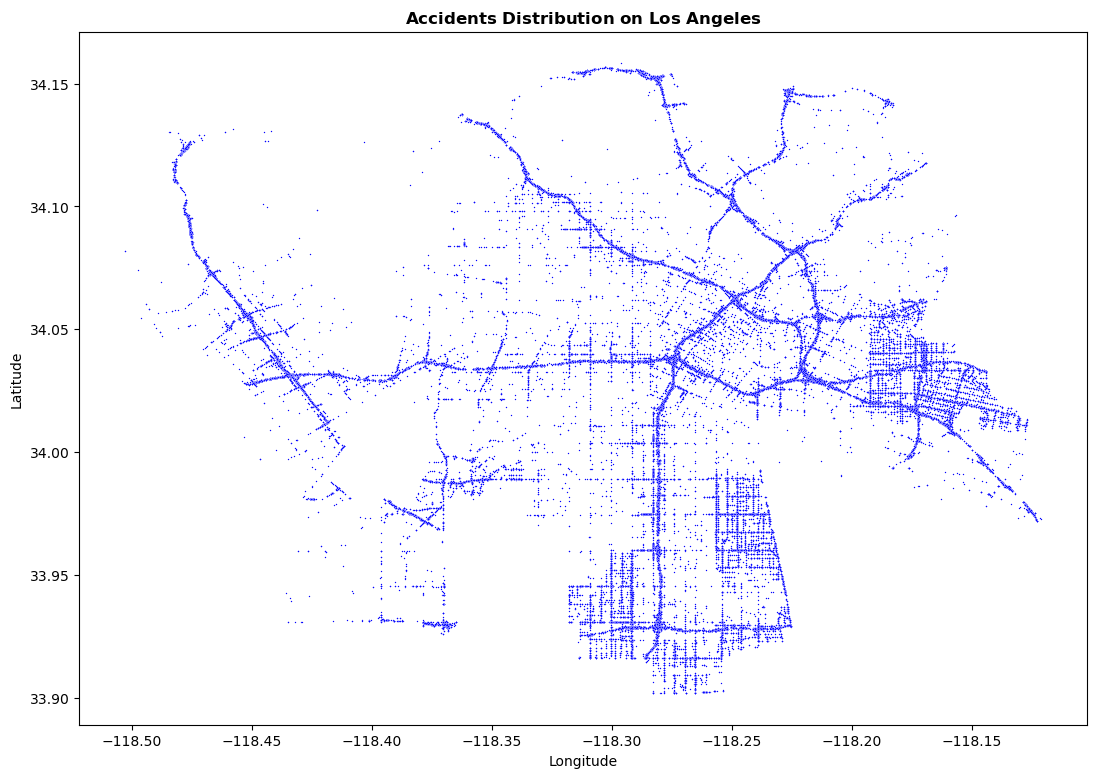

In [354]:
# Create a location scatter plot using Seaborn
plt.figure(figsize=(fig_w, fig_h))
sns.scatterplot(x=df_hs.Start_Lng, y=df_hs.Start_Lat, s=1, color='blue')

#plt.scatter(x=df_hs.Start_Lng, y=df_hs.Start_Lat, color='blue', s=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'$\mathrm{\mathbf{Accidents\ Distribution\ on\ %s}}$' % (city_name.replace(' ', '\ ')))


plt.savefig(make_png_file_name('original'))
plt.show()

#### 3.2 RAPPOR pertubated dataset
RAPPOR pertubated dataset distribution is showed below graph. In this case, founed on original dataset is shown.

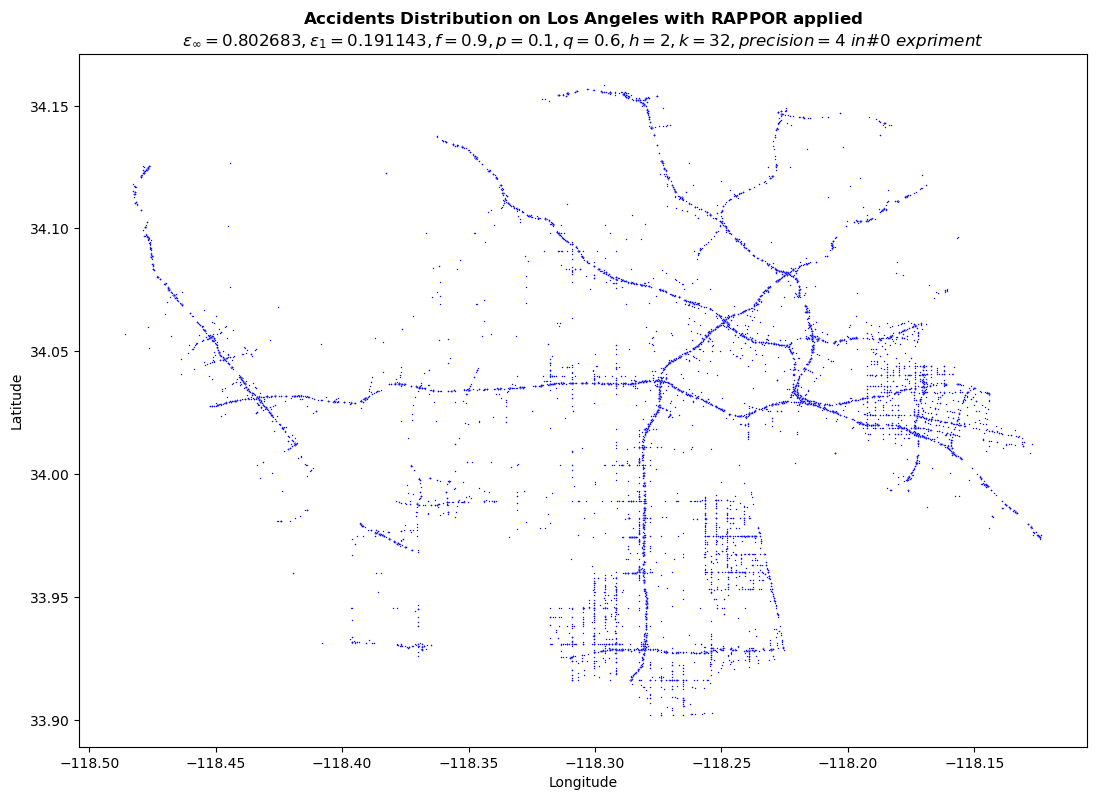

In [355]:
# Create a location scatter plot using Seaborn
plt.figure(figsize=(fig_w, fig_h))
sns.scatterplot(x=df_rappor_found.Start_Lng, y=df_rappor_found.Start_Lat, s=1, color='blue')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'$\mathrm{\mathbf{Accidents\ Distribution\ on\ %s\ with\ RAPPOR\ applied}}$' % (city_name.replace(' ', '\ ')) + '\n' + 
          r'$ε_{\infty}= %f, ε_1= %f, f = %s, p = %s, q = %s, h = %s, k = %s, precision = %s\ in \#%s\ expriment$' 
          % (e_p, e_1, f, p, q, hash_count, bloom_size, precision_round_digit, expriment))

plt.savefig(make_png_file_name('rappor'))
plt.show()

#### 3.3 RAPPOR pertubated dataset with comparing
RAPPRO pertubated dataset distribution is showed below graph.This data include all kind of dataset that RAPPOR generated. However, it distinguished by color.

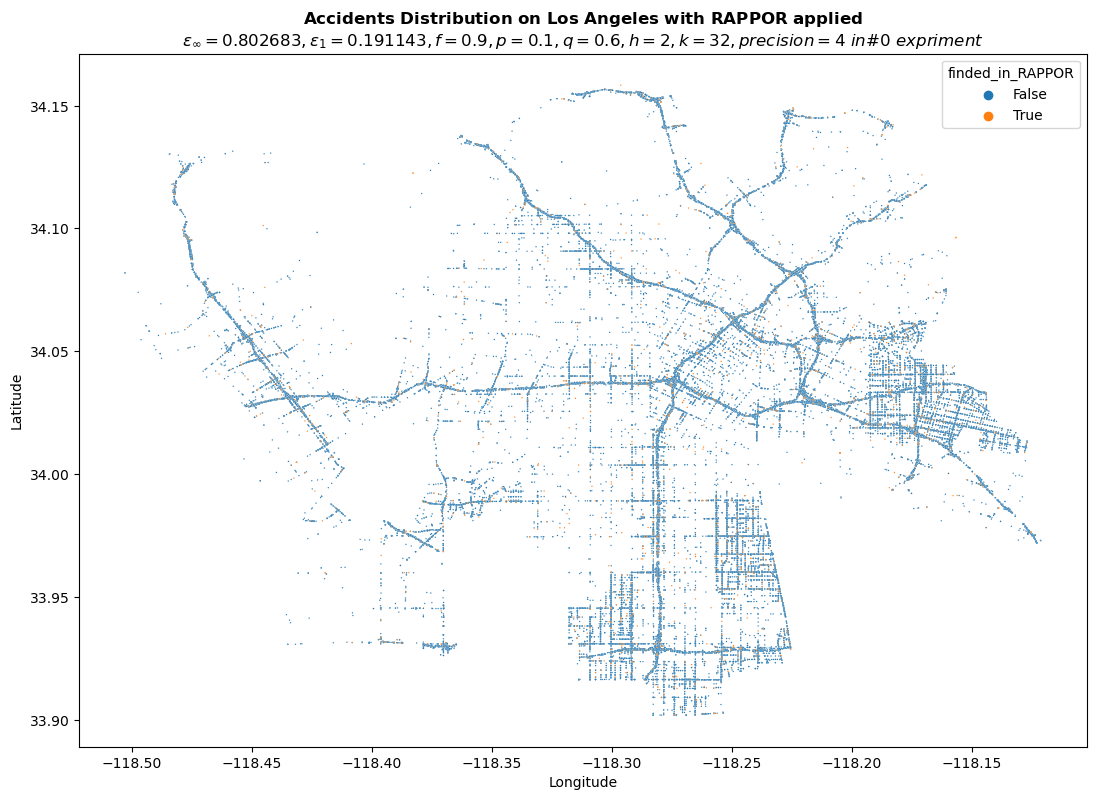

In [356]:
plt.figure(figsize=(fig_w, fig_h))
#colors = {False: 'red', True: 'black'}
sns.scatterplot(x=df_rappor.Start_Lng, y=df_rappor.Start_Lat, s=1, hue=df_rappor.finded_in_RAPPOR)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'$\mathrm{\mathbf{Accidents\ Distribution\ on\ %s\ with\ RAPPOR\ applied}}$' % (city_name.replace(' ', '\ ')) + '\n' + 
          r'$ε_{\infty}= %f, ε_1= %f, f = %s, p = %s, q = %s, h = %s, k = %s, precision = %s\ in \#%s\ expriment$' 
          % (e_p, e_1, f, p, q, hash_count, bloom_size, precision_round_digit, expriment))

plt.savefig(make_png_file_name('rappor_compare'))
plt.show()

#### 3.4 Original dataset and RAPPOR pertubated dataset
In here, two graphs are shown. Original dataset distribution and RAPPOR pertubated dataset are those. Output can check difference between them.

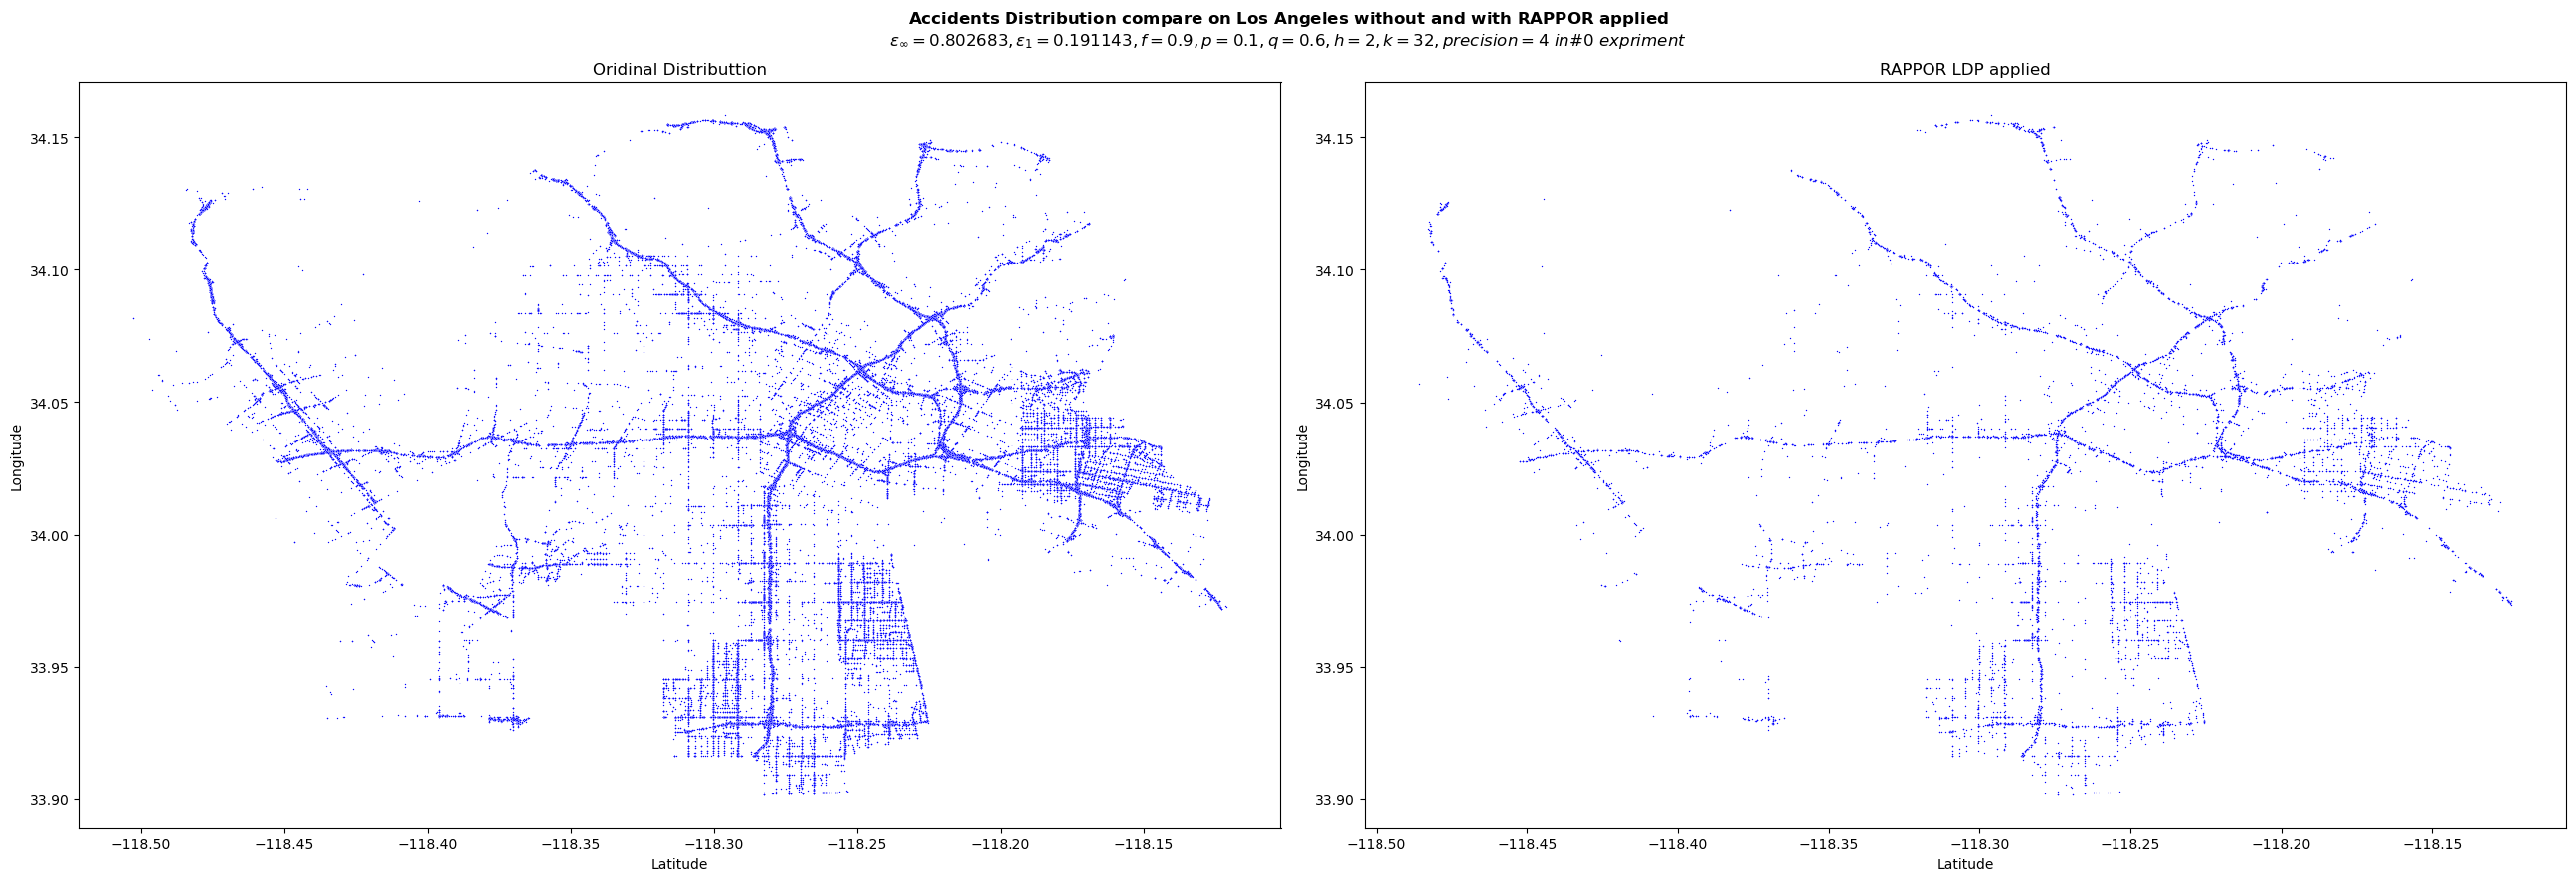

In [357]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(fig_w*2, fig_h))

# Plot the first graph on the left subplot using Seaborn
sns.scatterplot(x=df_hs.Start_Lng, y=df_hs.Start_Lat, ax=axes[0],s=1, color='blue')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Longitude')
axes[0].set_title('Oridinal Distributtion')

# Plot the second graph on the right subplot using Seaborn
sns.scatterplot(x=df_rappor_found.Start_Lng, y=df_rappor_found.Start_Lat, ax=axes[1],s=1, color='blue')
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Longitude')
axes[1].set_title('RAPPOR LDP applied')


plt.suptitle(r'$\mathrm{\mathbf{Accidents\ Distribution\ compare\ on\ %s\ without\ and\ with\ RAPPOR\ applied}}$' % (city_name.replace(' ', '\ ')) + '\n' + 
          r'$ε_{\infty}= %f, ε_1= %f, f = %s, p = %s, q = %s, h = %s, k = %s, precision = %s\ in \#%s\ expriment$' 
          % (e_p, e_1, f, p, q, hash_count, bloom_size, precision_round_digit, expriment))

# Display the subplots
plt.tight_layout()

plt.savefig(make_png_file_name('compare_original_rappor'))
plt.show()